# Analyse results from regression report
- Check the distribution y_pred compared to y_test
- Check the correlations from target `loudness` (with binwidth of `0.05`) with the most important features
- How do users report `loudness` within the year for different countries?

### Distribution of y_pred and y_test

In [1]:
p_loc = 'C:/Users/joa24jm/Documents/tinnitus-country/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import spearmanr

In [3]:
y_test = pd.read_csv(p_loc + 'data/04_models/y_test.csv', index_col='index')
x_test = pd.read_csv(p_loc + 'data/04_models/x_test.csv', index_col='index')

In [4]:
model_path = p_loc + 'results/04_models/best_estimator/gb_regressor/gb_21_07_12_16_34.sav'

# Load the Model back from file
with open(model_path, 'rb') as file:
    gb = pickle.load(file)

In [5]:
gb

GradientBoostingRegressor(learning_rate=0.5, max_depth=10, max_features=0.75,
                          random_state=42, subsample=1, verbose=1)

In [6]:
y_pred = gb.predict(x_test)

In [15]:
y_test

,reported_loudness,estimated_loudness
index,,
79885,0.180000,0.174683
63161,0.470000,0.573287
70955,0.040621,0.034889
48210,0.025735,0.071467
52353,1.000000,0.942397
...,...,...
13808,0.266544,0.057820
16383,0.790000,0.353910
79398,0.020000,0.039978


In [7]:
# little post-processing
y_pred = np.where(y_pred > 1, 1, y_pred)
y_pred = np.where(y_pred < 0, 0, y_pred)

In [8]:
res = pd.read_csv(p_loc + 'results/06_reports/regression_reports/gb_21_07_12_16_34.csv')

The gradient boosting machine underestimates the extreme values from `[0.0, 0.2)` and `[0.7, 1.0]`,
and overestimates in the middle ranges from `[0.2, 0.7)`.

In [9]:
dic = (dict((zip(x_test.columns, gb.feature_importances_))))
{k: v for k, v in sorted(dic.items(), key=lambda item: item[1])}

{'RU': 0.001564617451743012,
 'CA': 0.0023793270916620235,
 'IT': 0.0023984020939284098,
 'NO': 0.0029809487858589064,
 'AT': 0.004005770607977503,
 'NL': 0.006994795145202882,
 'CH': 0.008985429871409852,
 'US': 0.009645271600897254,
 'spring': 0.010962208755617035,
 'GB': 0.011135356496379294,
 'summer': 0.013191562459933963,
 'autumn': 0.013330201279390191,
 'winter': 0.015881838317825237,
 'DE': 0.019754157129697185,
 'Male': 0.033155737636983845,
 'question5': 0.047075259419085226,
 'question4': 0.07361243581241782,
 'question7': 0.14403335365881031,
 'question6': 0.2731327285608401,
 'age': 0.30578059782433986}

Most relevant features are `age`, `question6` (stress), `question7` (concentration),
`question4` (mood), `question5` (arousal).
Least important features are the countries.
That is, we can not generally say, that Canadian people have louder tinnitus than Non-Canadian, i.e.

### Correlations with the target `loudness`
- `loudness`, `age`, `stress`, `mood` have all continuous and non-parametric (= not normally distributed) distributions.
So we can apply the $\rho$ spearman correlation.

In [10]:
# create a df 'cache' than contains
cache = pd.DataFrame(y_test)
cache['estimated_loudness'] = y_pred
cache.rename(columns = {'question2': 'reported_loudness'}, inplace = True)

rho, pval = spearmanr(x_test.question6.values.tolist(), y_test['reported_loudness'].values.tolist())

In [11]:
x_test.rename(columns = {'question4': 'mood', 'question5': 'arousal',
                         'question6': 'stress', 'question7': 'concentration'}, inplace = True)

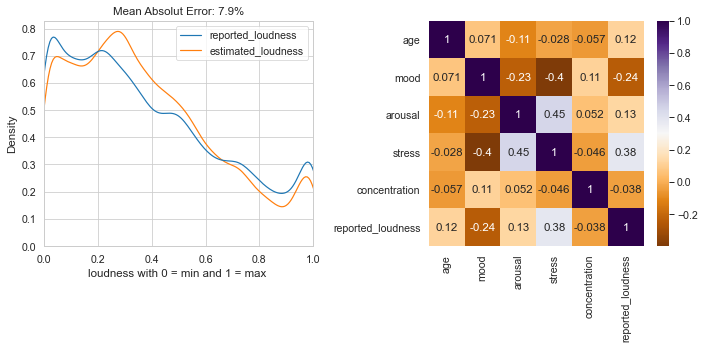

In [12]:
plt.close() # clear figure if replotted

sns.set_context("paper", font_scale=1.2)
sns.set_style('whitegrid')

fig, ax = plt.subplots(ncols = 2, nrows = 1)
fig.set_size_inches(10, 5)
sns.kdeplot(data = cache, ax = ax[0])
ax[0].set_xlim(xmin = 0, xmax = 1)
ax[0].set_title(f"Mean Absolut Error: " +  '{:.1%}'.format(res.mean_absolute_error[0]))
ax[0].set_xlabel('loudness with 0 = min and 1 = max ')

corr = x_test[['age', 'mood', 'arousal',
       'stress', 'concentration']].join(y_test['reported_loudness']).corr(method = 'spearman')
sns.heatmap(corr, annot = True, cmap = 'PuOr', ax = ax[1])
plt.tight_layout()
plt.savefig(p_loc + 'results/07_plots/heatmap_regression_loudness.pdf')

plt.show()